In [1009]:
import boto3
from langchain.document_loaders import AmazonTextractPDFLoader
from langchain.llms import Bedrock
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
import json
import pandas as pd
from datetime import datetime

## Input Data Loads

In [625]:
# Load test dataset
df = pd.read_csv(
    "input/dataset_test.csv"
)
df.head()

,file,text,Company Name,As-Converted Common,Date,Source,Shares Type,# Shares,Issue price/share,Conversion Ratio,Liq.Pref,Liq. Pref Order,Participation,Cap,Dividend,Cumulative,Authorized
0,earnin_2020-09-04,AMENDED AND RESTATED CERTIFICATE OF INCORPORAT...,"Activehours, Inc.",54850000.0,2013-05-21,COI 09/19/2022,"['Series 1', 'Series 2', 'Series 3', 'Series 4...","[4413518.0, 9099723.0, 8745388.0, 7527844.0, 2...","[0.6, 1.9061, 3.7677, 16.6373, 10.1427]","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]","['No', 'No', 'No', 'No', 'No']","[nan, nan, nan, nan, nan]","[0.08, 0.08000629558, 0.07999575338, 0.0800009...","['No', 'No', 'No', 'No', 'No']","['No', 'No', 'No', 'No', 'No']"
1,eaze_2022-08-15,AMENDED AND RESTATED CERTIFICATE OF INCORPORAT...,"Eaze Technologies, Inc.",480000000.0,2014-09-08,COI 08/15/2022,"['Series A', 'Series B', 'Series C', 'Series D...","[4510638.0, 15823599.0, 22118095.0, 109904126....","[4.1476, 4.55924, 7.718, 1.3672, 1.3672, 1.6853]","[1.960317235, 2.035783974, 2.454350605, 1.0339...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","['No', 'No', 'No', 'No', 'No', 'No']","[nan, nan, nan, nan, nan, nan]","[0.06001060854, 0.05999903493, 0.06, 0.0599765...","['No', 'No', 'No', 'No', 'No', 'No']","['No', 'No', 'No', 'No', 'No', 'No']"
2,echopayment_2022-11-09,State of Delaware\nSecretary of State\nDivisio...,"ECHO Payment Systems, Inc.",7000000.0,2016-11-01,COI 11/09/2022,"['Series A', 'Series B']","[1600000.0, 1250000.0]","[4.875, 50.0]","[1.0, 1.0]","[1.0, 1.0]","[1.0, 2.0]","['Yes', 'Yes']","[1000.0, 1000.0]","[0.06, 0.12]","['Yes', 'Yes']","['Yes', 'Yes']"
3,elementenergy_2022-09-19,State of Delaware\nSecretary of State\nDivisio...,"Element Energy, Inc.",26700000.0,2019-01-22,COI 09/19/2022,"['Series A', 'Series A-1', 'Series B']","[6820556.0, 2118257.0, 3118423.0]","[1.4383, 2.5233, 12.827]","[1.0, 1.0, 1.0]","[1.0, 1.0, 1.0]","[2.0, 2.0, 1.0]","['No', 'No', 'No']","[nan, nan, nan]","[0.07, 0.07, 0.07]","['No', 'No', 'No']","['No', 'No', 'No']"
4,embroker_2021-05-11,State of Delaware\nSecretary of State\nDivisio...,"Embroker, Inc.",63100000.0,2015-02-13,COI 05/11/2021,"['Series Seed', 'Series A', 'Series A1', 'Seri...","[4146363.0, 6483805.0, 5528198.0, 10549702.0, ...","[0.5412, 1.2724, 1.50168, 2.48, 7.5955]","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0]","['No', 'No', 'No', 'No', 'No']","[nan, nan, nan, nan, nan]","[0.08000739098, 0.08000628733, 0.07997709232, ...","['No', 'No', 'No', 'No', 'No']","['No', 'No', 'No', 'No', 'No']"


In [361]:
# Files provided by Alice, now stored in S3

# using Amazon Textract to convert PDF to text
textract_client = boto3.client("textract", region_name="us-west-2")

# inital pulled COI's to test
dataminr_file_path = "s3://idp-coi-test/input/dataminr 2021-05-04 COI.pdf"
moxion_file_path = "s3://idp-coi-test/input/moxion-power 2022-07-29 COI Labeled.pdf"
dnanexus_file_path = "s3://idp-coi-test/input/dnanexus 2022-03-03 COI.pdf"

# identified as complicated
openexchange_file_path = "s3://idp-coi-test/input/openexchange 2021-06-07 COI-1 Labeled1.pdf"  # complicated, contains participation
playon_file_path = "s3://idp-coi-test/input/playon-sports 2020-11-25 COI.pdf"
toca_file_path = "s3://idp-coi-test/input/toca-football 2021-06-04 COI.pdf"

# identified as containing participation
better_mortgage_file_path = "s3://idp-coi-test/input/better-mortgage 2020-11-02 COI.pdf"
capstan_file_path = "s3://idp-coi-test/input/capstan-therapeutics 2022-06-14 COI.pdf"
cg_oncology_file_path = "s3://idp-coi-test/input/cg-oncology 2022-09-30 COI Labeled.pdf"  # seems to be working pretty well

# greater than 10 preference types
callminer_file_path = "s3://idp-coi-test/input/callminer 2022-05-26 COI.pdf"
boxed_file_path = "s3://idp-coi-test/input/boxed 2021-08-04 COI.pdf"

# identified as most straightforward
boulevard_file_path = "s3://idp-coi-test/input/boulevard 2022-04-18 COI.pdf"
amplify_file_path = "s3://idp-coi-test/input/amplify 2022-08-23 COI.pdf"
albert_file_path = "s3://idp-coi-test/input/albert 2021-01-12 COI.pdf"

In [362]:
# loading all of the files and extracting the text using Amazon Textract
file_paths = [
    dataminr_file_path,
    moxion_file_path,
    dnanexus_file_path,
    openexchange_file_path,
    playon_file_path,
    toca_file_path,
    better_mortgage_file_path,
    capstan_file_path,
    cg_oncology_file_path,
    callminer_file_path,
    boxed_file_path,
    boulevard_file_path,
    amplify_file_path,
    albert_file_path,
]

document_dict = {}

In [371]:
for file_path in file_paths:
    company_name = file_path.split(" ")[0].split("/")[-1]
    if company_name in document_dict:
        print(company_name, "in if")
        continue
    else:
        print(company_name, "in else")
        # extracts text from PDF document using Amazon Textract
        loader = AmazonTextractPDFLoader(file_path, client=textract_client)

        # loads document
        document = loader.load()

        # given 200k context window for Anthropic Claude  V2, joining all pages into 1 document content
        ttl_document_content = "".join([page.page_content for page in document])

        document_dict[company_name] = ttl_document_content

dataminr in if
moxion-power in if
dnanexus in else
openexchange in else
playon-sports in else
toca-football in else
better-mortgage in else
capstan-therapeutics in else
cg-oncology in else
callminer in else
boxed in else
boulevard in else
amplify in else
albert in else


## Intelligent Document Processing
Source: https://aws.amazon.com/blogs/machine-learning/intelligent-document-processing-with-amazon-textract-amazon-bedrock-and-langchain/

## Simple prompting techniques

### Zero-shot learning

In [1336]:
# output template that will be used as the format instructions for the llm template
output_template = {
    "company_name": {
        "type": "string",
        "description": "The company's name",
        "example": "ABC Corp",
    },
    "series_name": {
        "type": "string",
        "description": "Names of Series of Preferred Stock Shares. Only include the name",
        "example": "['Series A', 'Series B']",
    },
    "delivery_date": {
        "type": "string",
        "description": "The date of the document was delivered, this should be formatted in YYYY-MM-DD format",
        "example": "10/01/2020",
    },
    "incorporation_date": {
        "type": "string",
        "description": "The incorporation date of the company, this should be formatted in YYYY-MM-DD format",
        "example": "11/15/YYYY",
    },
    "common_shares": {
        "type": "string",
        "description": "Total shares of common stock",
        "example": "5000",
    },
    "share_amount": {
        "type": "string",
        "description": "The amount of shares for each series of preferred stock shares",
        "example": "{'Series A': '1000', 'Series A-1': '2000', 'Series B(a)': '10000'}",
    },
    "issue_price": {
        "type": "string",
        "description": "The issue price for each series of preferred stock shares",
        "example": "{'Series A': '10.00', 'Series A-1': '9.51', 'Series C2': '.198'}",
    },  # Format it as a json object with the series name as the key and the issue price as the value. Example: {'Series A': '10.00', 'Series B': '9.891'}"}
    "liquidation_price": {
        "type": "string",
        "description": "The liquidation price for each series of preferred stock shares",
        "example": "{'Series A': '10.00', 'Series A-1': '9.51', 'Series C': '0.198'}",
    },
    # "conversion_price": {
    #     "type": "string",
    #     "description": "The conversion price for each series of preferred stock shares",
    #     "example": "{'Series A': '10.00', 'Series B-1': '9.51', 'Series D': '0.198'}",
    # },
    # "dividend_amount":{ "type": "string", "description": "The dividend rate or per share amount for each series of preferred stock shares", "example": "{'Series A': '8%', 'Series B-1': '2.51', 'Series D': '10.5%'}"},
    # "dividend_cumulative":{ "type": "string", "description": "Identify whether dividend is cumulative for each of the series of preferred stock shares", "example": "{'Series A': 'Cumulative', 'Series B-1': 'Not Cumulative', 'Series D': 'Cumulative'}"},
    # "liquidation_pref":{ "type": "string", "description": "Summarize the liquidation preference order explicitly accounting for all of the series of preferred stock shares. This can also be referred to as Preferential Payments to Holders of Series Preferred or Liquidation", "example": "Series C > Series D and Series B1 > Series A"},
    # "participation_cap":{ "type": "string", "description": "Summarize participation or distribution of the remaining assets if necessary for the various share classes", "example": "Summary..."}
    # "liquidation_pref":{ "type": "string", "description": "The liquidation preference order explicitly accounting for each of the series of preferred stock shares. This can also be referred to as Preferential Payments to Holders of Series Preferred or Liquidation", "example": "Series C > Series D and Series B1 > Series A"},
    # "participation_cap":{ "type": "string", "description": "The participation / liquidation cap / amount of each share type", "example": "{'Series A': '2x Cap', 'Series B-1': 'No Cap', 'Series D': '10 times', 'Series E': 'Not Found', 'Series A-1': '50%'}"}
}


details = "\n".join(
    [
        f"{key}: {value['description']}. For example, {value['example']}"
        for key, value in output_template.items()
    ]
)
keys = "\n".join([f"{key}" for key, value in output_template.items()])

In [1338]:
from langchain.output_parsers import ResponseSchema
from langchain.output_parsers import StructuredOutputParser

response_schems = list()

for key, value in output_template.items():
    schema = ResponseSchema(
        name=key,
        description=f"{value['description']}. For example, {value['example']}",
        type=value["type"],
    )
    # schema = ResponseSchema(name=key, description=value['description'], type=value['type']) #description=value['description']
    response_schems.append(schema)
output_parser = StructuredOutputParser.from_response_schemas(response_schems)
format_instructions = output_parser.get_format_instructions()
print(format_instructions)

The output should be a markdown code snippet formatted in the following schema, including the leading and trailing "```json" and "```":

```json
{
	"company_name": string  // The company's name. For example, ABC Corp
	"series_name": string  // Names of Series of Preferred Stock Shares. Only include the name. For example, ['Series A', 'Series B']
	"delivery_date": string  // The date of the document was delivered, this should be formatted in YYYY-MM-DD format. For example, 10/01/2020
	"incorporation_date": string  // The incorporation date of the company, this should be formatted in YYYY-MM-DD format. For example, 11/15/YYYY
	"common_shares": string  // Total shares of common stock. For example, 5000
	"share_amount": string  // The amount of shares for each series of preferred stock shares. For example, {'Series A': '1000', 'Series A-1': '2000', 'Series B(a)': '10000'}
	"issue_price": string  // The issue price for each series of preferred stock shares. For example, {'Series A': '10.00'

In [1339]:
template = """

You are a helpful assistant. 

Please extract the following details from the document and strictly follow the instructions described in the format instructions to format the output. 

Skip any preamble text and generate the final answer only. The answer should only consist of the json object.

<details>
{details}
</details>

<keys>
{keys}
</keys>

<format_instructions>
{format_instructions}
</format_instructions>

<document>
{doc_text}
</document>

<final_answer>"""

In [1340]:
# using test database
row_to_use = 6
entire_document_content = df.iloc[row_to_use, :]["text"]

# entire_document_content = document_dict['capstan-therapeutics']

bedrock = boto3.client("bedrock-runtime", region_name="us-west-2")
prompt = PromptTemplate(
    template=template,
    input_variables=["details", "keys", "format_instructions", "doc_text"],
)
bedrock_llm = Bedrock(client=bedrock, model_id="anthropic.claude-v2")
# bedrock_llm = Bedrock(client=bedrock, model_id="amazon.titan-text-express-v1")


# llm_chain = LLMChain(prompt=prompt, llm=bedrock_llm, llm_kwargs={"max_tokens_to_sample":5000, 'temperature':0})
llm_chain = LLMChain(prompt=prompt, llm=bedrock_llm, llm_kwargs={"temperature": 0})
output = llm_chain.run(
    {
        "doc_text": entire_document_content,
        "details": details,
        "keys": keys,
        "format_instructions": format_instructions,
    }
)

num_tokens = bedrock_llm.get_num_tokens(entire_document_content)
num_tokens_output = bedrock_llm.get_num_tokens(output)
print(f"{num_tokens} document tokens | {num_tokens_output} output tokens")
print("----------------------------------------")
start_index = output.find("`json\n") + len("`json\n")
end_index = output.rfind("```")
json_string = output[start_index:end_index]

data = json.loads(json_string)
data

17436 document tokens | 214 output tokens
----------------------------------------


{'company_name': 'Endgame Labs, Inc.',
 'series_name': ['Series Seed', 'Series A', 'Series B'],
 'delivery_date': '2021-11-02',
 'incorporation_date': '2020-12-02',
 'common_shares': '21500000',
 'share_amount': {'Series Seed': '3257924',
  'Series A': '4047964',
  'Series B': '2223573'},
 'issue_price': {'Series Seed': '1.53472',
  'Series A': '3.02621',
  'Series B': '13.41938'},
 'liquidation_price': {'Series Seed': '1.53472',
  'Series A': '3.02621',
  'Series B': '13.41938'}}

In [ ]:
print(df.iloc[row_to_use, :])

file                                          endgamesoftware_2021-11-02
text                   State of Delaware\nSecretary of State\nDivisio...
Company Name                                          Endgame Labs, Inc.
As-Converted Common                                           21500000.0
Date                                                          2020-12-02
Source                                                    COI 11/02/2021
Shares Type                      ['Series Seed', 'Series A', 'Series B']
# Shares                               [3257924.0, 4047964.0, 2235573.0]
Issue price/share                           [1.53472, 3.02621, 13.41938]
Conversion Ratio                                         [1.0, 1.0, 1.0]
Liq.Pref                                                 [1.0, 1.0, 1.0]
Liq. Pref Order                                          [1.0, 1.0, 1.0]
Participation                                         ['No', 'No', 'No']
Cap                                                

## Evaluation and Post Processing

In [ ]:
share_type_gt_list = eval(df.iloc[row_to_use, :]["Shares Type"])
for i, share_type in enumerate(share_type_gt_list):
    print("llm:", data["share_amount"][share_type])
    print("llm_float", float(data["share_amount"][share_type].replace(",", "")))
    print("gt:", eval(df.iloc[row_to_use, :]["# Shares"])[i])

llm: 3,257,924
llm_float 3257924.0
gt: 3257924.0
llm: 4,047,964
llm_float 4047964.0
gt: 4047964.0
llm: 2,235,573
llm_float 2235573.0
gt: 2235573.0


In [ ]:
def run_llm(entire_document_content):
    bedrock = boto3.client("bedrock-runtime", region_name="us-west-2")
    prompt = PromptTemplate(
        template=template,
        input_variables=["details", "keys", "format_instructions", "doc_text"],
    )
    bedrock_llm = Bedrock(client=bedrock, model_id="anthropic.claude-v2")

    llm_chain = LLMChain(
        prompt=prompt,
        llm=bedrock_llm,
        llm_kwargs={"max_tokens_to_sample": 5000, "temperature": 0},
    )
    output = llm_chain.run(
        {
            "doc_text": entire_document_content,
            "details": details,
            "keys": keys,
            "format_instructions": format_instructions,
        }
    )

    start_index = output.find("`json\n") + len("`json\n")
    end_index = output.rfind("```")
    json_string = output[start_index:end_index]

    data = json.loads(json_string)
    return data

In [ ]:
def dictionary_input(
    file_name, field_gt_label, field_llm_label, gt_value, llm_value, gt_share_type=None
):
    return {
        "file_name": file_name,
        "field_gt": field_gt_label,
        "field_llm": field_llm_label,
        "share_type_gt": gt_share_type,
        "value_gt": gt_value,
        "value_llm": llm_value,
        "exact_match": gt_value == llm_value,
    }

In [ ]:
files_processed_list = []

In [1021]:
import time

In [1024]:
processed_files = []
llm_output_list = []
for idx in range(len(df)):
    start_time = time.time()
    document_text = df.iloc[idx, :]["text"]
    llm_output_data = run_llm(document_text)

    file_name = df.iloc[idx, :]["file"]

    llm_output_list.append(llm_output_data)
    processed_files.append(file_name)
    end_time = time.time()
    print(f"{idx}: {file_name} -- {round(end_time - start_time, 2)}s")

0: earnin_2020-09-04 -- 22.43s
1: eaze_2022-08-15 -- 22.17s
2: echopayment_2022-11-09 -- 20.43s
3: elementenergy_2022-09-19 -- 22.17s
4: embroker_2021-05-11 -- 25.86s
5: enable_2022-05-24 -- 29.18s
6: endgamesoftware_2021-11-02 -- 21.92s
7: equipmentshare_2022-05-04 -- 44.34s
8: escientpharmaceuticals_2022-11-14 -- 25.8s
9: essencegroupholdings_2018-07-27 -- 40.04s
10: esusu_2022-12-27 -- 28.28s
11: execonline_2021-04-14 -- 37.57s
12: facetwealth_2021-12-21 -- 31.37s
13: federatedwireless_2022-04-28 -- 31.71s
14: fervoenergy_2022-08-08 -- 24.78s
15: fever_2023-01-11 -- 29.72s
16: fireflyaerospace_2023-02-01 -- 28.75s
17: flash_2022-04-08 -- 34.95s
18: flatfile_2022-03-11 -- 24.16s
19: flipboard_2021-06-16 -- 22.09s
20: flutterwave_2022-01-27 -- 28.16s
21: flyr_2021-11-19 -- 26.91s
22: fogpharma_2020-12-22 -- 25.31s
23: formenergy_2022-09-19 -- 34.82s
24: fortanix_2022-11-14 -- 26.13s
25: froresystems_2021-12-10 -- 22.11s
26: fulfilsolutions_2022-10-10 -- 20.77s
27: fungible_2022-08-23 

In [1025]:
df["llm_output"] = llm_output_list

In [1067]:
import re

def clean_string(s):
    return re.sub(r"\s+Preferred Stock$", "", s)

In [1341]:
count = 0
output_dict = {}
for idx in range(len(df)):
    document_text = df.iloc[idx, :]["text"]
    llm_output_data = df.iloc[idx, :]["llm_output"]

    file_name = df.iloc[idx, :]["file"]

    # Company Name
    output_dict[count] = dictionary_input(
        file_name,
        field_gt_label="Company Name",
        field_llm_label="company_name",
        gt_value=df.iloc[idx, :]["Company Name"].lower(),
        llm_value=llm_output_data["company_name"].lower(),
    )
    count += 1

    # Common Shares
    output_dict[count] = dictionary_input(
        file_name,
        field_gt_label="As-Converted Common",
        field_llm_label="common_shares",
        gt_value=df.iloc[idx, :]["As-Converted Common"],
        llm_value=float(llm_output_data["common_shares"].replace(",", "")),
    )
    count += 1

    # Incorporation Date
    output_dict[count] = dictionary_input(
        file_name,
        field_gt_label="Date",
        field_llm_label="incorporation_date",
        gt_value=datetime.strptime(df.iloc[idx, :]["Date"], "%Y-%m-%d").date(),
        llm_value=datetime.strptime(
            llm_output_data["incorporation_date"], "%Y-%m-%d"
        ).date(),
    )
    count += 1

    # COI Delivery Date
    output_dict[count] = dictionary_input(
        file_name,
        field_gt_label="Source",
        field_llm_label="delivery_date",
        gt_value=datetime.strptime(
            df.iloc[idx, :]["Source"].split(" ")[1], "%m/%d/%Y"
        ).date(),
        llm_value=datetime.strptime(
            llm_output_data["delivery_date"], "%Y-%m-%d"
        ).date(),
    )
    count += 1

    # Share Types
    if type(llm_output_data["series_name"]) == str:
        llm_series_name_list = eval(llm_output_data["series_name"])

        llm_series_name_set = set([clean_string(s) for s in llm_series_name_list])
    else:
        llm_series_name_set = set(
            [clean_string(s) for s in llm_output_data["series_name"]]
        )
    output_dict[count] = dictionary_input(
        file_name,
        field_gt_label="Shares Type",
        field_llm_label="series_name",
        gt_value=set(eval(df.iloc[idx, :]["Shares Type"])),
        llm_value=llm_series_name_set,
    )
    count += 1

    # Per Share Type Values
    # share amount
    if type(llm_output_data["share_amount"]) == str:
        share_amount_llm_dict = eval(llm_output_data["share_amount"])
    else:
        share_amount_llm_dict = llm_output_data["share_amount"]

    # issue price
    if type(llm_output_data["share_amount"]) == str:
        issue_price_llm_dict = eval(llm_output_data["issue_price"])
    else:
        issue_price_llm_dict = llm_output_data["issue_price"]

    share_type_gt_list = eval(df.iloc[idx, :]["Shares Type"])
    for i, share_type in enumerate(share_type_gt_list):
        # Number of Shares

        if share_type in share_amount_llm_dict:
            llm_share_amount_value = float(
                share_amount_llm_dict[share_type].replace(",", "")
            )

        elif f"{share_type} Preferred Stock" in share_amount_llm_dict:
            llm_share_amount_value = float(
                share_amount_llm_dict[f"{share_type} Preferred Stock"].replace(",", "")
            )

        else:
            llm_share_amount_value = None

        output_dict[count] = dictionary_input(
            file_name,
            field_gt_label="# of Shares",
            field_llm_label="share_amount",
            gt_value=eval(df.iloc[idx, :]["# Shares"])[i],
            llm_value=llm_share_amount_value,
            gt_share_type=share_type,
        )
        count += 1

        if share_type in issue_price_llm_dict:
            llm_issue_price_value = float(
                issue_price_llm_dict[share_type].replace(",", "")
            )

        elif f"{share_type} Preferred Stock" in issue_price_llm_dict:
            llm_share_amount_value = float(
                issue_price_llm_dict[f"{share_type} Preferred Stock"].replace(",", "")
            )
        else:
            llm_issue_price_value = None
        output_dict[count] = dictionary_input(
            file_name,
            field_gt_label="Issue price/share",
            field_llm_label="issue_price",
            gt_value=eval(df.iloc[idx, :]["Issue price/share"])[i],
            llm_value=llm_issue_price_value,
            gt_share_type=share_type,
        )
        count += 1

    files_processed_list.append(file_name)
    # if idx > 2:
    #     break

In [1342]:
dfo = pd.DataFrame.from_dict(output_dict, orient="index")
dfo.head(5)

,file_name,field_gt,field_llm,share_type_gt,value_gt,value_llm,exact_match
0,earnin_2020-09-04,Company Name,company_name,None,"activehours, inc.","activehours, inc.",True
1,earnin_2020-09-04,As-Converted Common,common_shares,None,54850000.0,54850000.0,True
2,earnin_2020-09-04,Date,incorporation_date,None,2013-05-21,2013-05-21,True
3,earnin_2020-09-04,Source,delivery_date,None,2022-09-19,2020-09-04,False
4,earnin_2020-09-04,Shares Type,series_name,None,"{Series 5, Series 4, Series 1, Series 3, Serie...","{Series 5, Series 4, Series 1, Series 3, Serie...",True


## Results

In [1343]:
dfo.groupby("field_llm").agg({"exact_match": "mean"}).reset_index()

,field_llm,exact_match
0,common_shares,0.933333
1,company_name,1.000000
2,delivery_date,0.700000
3,incorporation_date,0.966667
4,issue_price,0.976471
5,series_name,0.966667
6,share_amount,0.952941


## Results from Provectus:

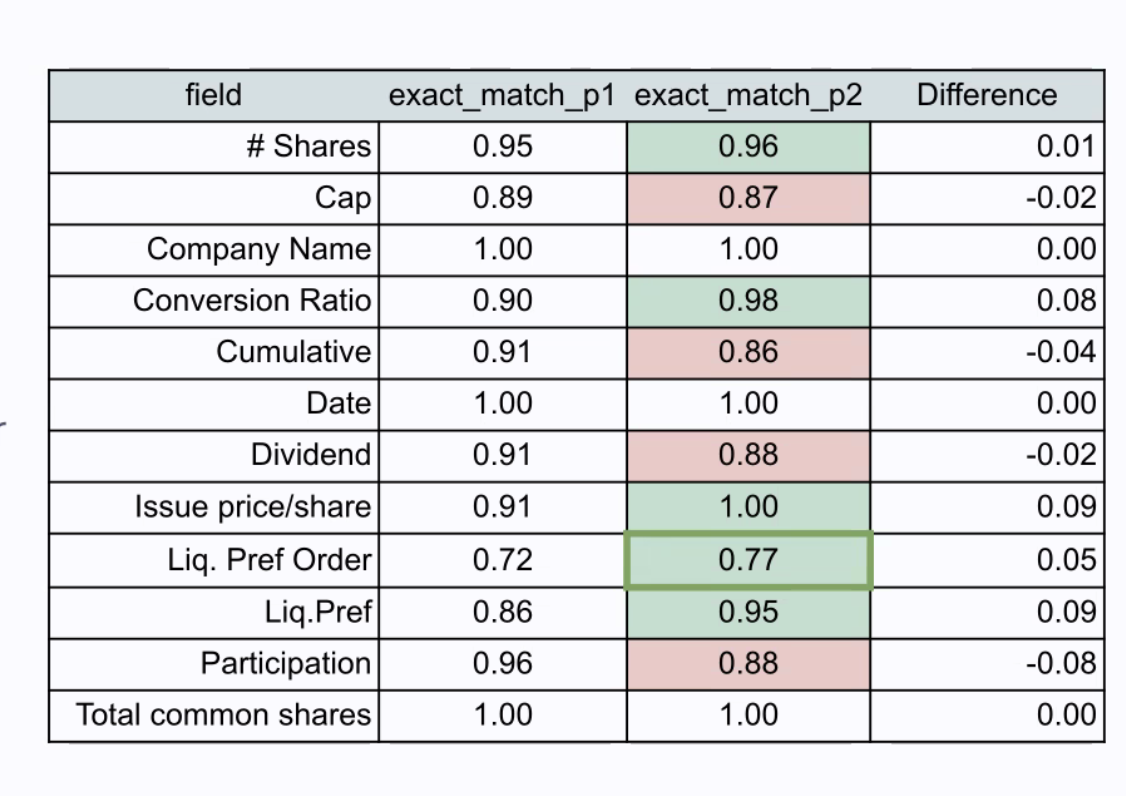

#### Series Name misses

In [1080]:
dfo[(dfo["field_llm"] == "series_name") & (dfo["exact_match"] == 0)]

,file_name,field_gt,field_llm,share_type_gt,value_gt,value_llm,exact_match
417,froresystems_2021-12-10,Shares Type,series_name,None,"{Series A-2, Series B, Series A-1, Series A}","{Series A-1, Series A, Series B, Series A-2, FF}",False


#### Share Amount misses

In [1082]:
dfo[(dfo["field_llm"] == "share_amount") & (dfo["exact_match"] == 0)]

,file_name,field_gt,field_llm,share_type_gt,value_gt,value_llm,exact_match
74,enable_2022-05-24,# of Shares,share_amount,Series B,7666092.0,7666902.0,False
80,enable_2022-05-24,# of Shares,share_amount,Series C-1,385109.0,385100.0,False
209,facetwealth_2021-12-21,# of Shares,share_amount,Series C-2,8093649.0,8093849.0,False
311,flatfile_2022-03-11,# of Shares,share_amount,Series Pre-Seed,4247478.0,4247.0,False
313,flatfile_2022-03-11,# of Shares,share_amount,Series Seed,5346027.0,5346.0,False
315,flatfile_2022-03-11,# of Shares,share_amount,Series A,5705996.0,5705.0,False
317,flatfile_2022-03-11,# of Shares,share_amount,Series B,6285827.0,6285.0,False
433,fulfilsolutions_2022-10-10,# of Shares,share_amount,Series Seed-1,5107914.0,5107194.0,False


#### Issue Price / Share misses

In [1083]:
dfo[(dfo["field_llm"] == "issue_price") & (dfo["exact_match"] == 0)]

,file_name,field_gt,field_llm,share_type_gt,value_gt,value_llm,exact_match
419,froresystems_2021-12-10,Issue price/share,issue_price,Series A,1.3241,1.00232,False
421,froresystems_2021-12-10,Issue price/share,issue_price,Series A-1,3.8228,1.00232,False
423,froresystems_2021-12-10,Issue price/share,issue_price,Series A-2,7.2247,1.00232,False
425,froresystems_2021-12-10,Issue price/share,issue_price,Series B,13.6106,1.00232,False


#### Common Shares misses

In [1084]:
dfo[(dfo["field_llm"] == "common_shares") & (dfo["exact_match"] == 0)]

,file_name,field_gt,field_llm,share_type_gt,value_gt,value_llm,exact_match
307,flatfile_2022-03-11,As-Converted Common,common_shares,None,40000000.0,40000.0,False
320,flipboard_2021-06-16,As-Converted Common,common_shares,None,5300000000.0,10600000.0,False


#### Company Name misses

In [1085]:
dfo[(dfo["field_llm"] == "company_name") & (dfo["exact_match"] == 0)]

,file_name,field_gt,field_llm,share_type_gt,value_gt,value_llm,exact_match


#### Delivery Date misses

In [1086]:
dfo[(dfo["field_llm"] == "delivery_date") & (dfo["exact_match"] == 0)]

,file_name,field_gt,field_llm,share_type_gt,value_gt,value_llm,exact_match
3,earnin_2020-09-04,Source,delivery_date,None,2022-09-19,2020-09-04,False
70,enable_2022-05-24,Source,delivery_date,None,2022-10-07,2022-05-24,False
354,flyr_2021-11-19,Source,delivery_date,None,2022-08-01,2021-11-19,False
403,fortanix_2022-11-14,Source,delivery_date,None,2022-04-05,2022-11-14,False
416,froresystems_2021-12-10,Source,delivery_date,None,2022-10-10,2021-12-10,False
429,fulfilsolutions_2022-10-10,Source,delivery_date,None,2022-08-23,2022-10-10,False
444,fungible_2022-08-23,Source,delivery_date,None,2022-12-06,2022-08-23,False
467,galileohealth_2022-12-06,Source,delivery_date,None,2020-12-30,2022-12-06,False
482,genalyte_2020-12-30,Source,delivery_date,None,2022-11-14,2020-12-30,False


#### Incorporation Date misses

In [1087]:
dfo[(dfo["field_llm"] == "incorporation_date") & (dfo["exact_match"] == 0)]

,file_name,field_gt,field_llm,share_type_gt,value_gt,value_llm,exact_match
353,flyr_2021-11-19,Date,incorporation_date,None,2013-07-09,2021-11-15,False


# Advanced prompting techniques

### Zero-shot learning but requesting LLM to quote specific source text

In [1291]:
# template = """

# You are a helpful assistant. Please extract the following details from the document along with the specific supporting text and strictly follow the instruction prompt. Skip any preamble text and generate the final answer only.

# <details>
# {details}
# </details>

# <document>
# {doc_text}
# </document>

# <final_answer>"""


# bedrock = boto3.client("bedrock-runtime", region_name="us-west-2")
# bedrock_llm = Bedrock(client=bedrock, model_id="anthropic.claude-v2")

# prompt = PromptTemplate(template=template, input_variables=["details", "doc_text"])
# llm_chain = LLMChain(
#     prompt=prompt,
#     llm=bedrock_llm,
#     llm_kwargs={"max_tokens_to_sample": 5000, "temperature": 0},
# )

In [1293]:
# # prompts
# company_name_details = "company_name: The company's name. For example, ABC Corp. \supporting_text: Quote the specific text used to extract the company_name_details."
# series_names_details = "series_name: Names of Series of Preferred Stock Shares. For example, ['Series A', 'Series B', 'Series B-1'] \supporting_text: Quote the specific text used to extract the series_names_details."
# coi_delivery_date_details = "delivery_date: Document delivery date, formatted in YYYY-MM-DD format. For example, 2020-10-01 \supporting_text: Quote the specific text used to extract the coi_delivery_date_details."
# coi_incorporation_date_details = "incorporation_date: Incorporation date, formatted in YYYY-MM-DD format. For example, 2020-10-01 \supporting_text: Quote the specific text used to extract the coi_incorporation_date_details."
# common_share_details = "common_shares: Total number of common shares. For example, 5,000 \supporting_text: Quote the specific text used to extract the common_shares."
# shares_per_series_details = "shares_per_series: Total number of shares for each series of preferred stock. For example, {'Series A': '1,000', 'Series A-1': '200', 'Series B(a)': '10,000'} \supporting_text: Quote the specific text used to extract the shares_per_series."
# issue_price_per_series_details = "issue_price_per_series: Issue price for each series of preferred stock. For example, {'Series A': '10.00', 'Series A-1': '9.51', 'Series B(a)': '0.198'} \supporting_text: Quote the specific text used to extract the issue_price_per_series."
# # liqidation_price_per_series_details = "liquidation_price_per_series: Liquidation price for each series of preferred stock. For example, {'Series A': '10.00', 'Series A-1': '9.51', 'Series B(a)': '0.198'} \supporting_text: Quote the specific text used to extract the liquidation_price_per_series."
# # dividend_rate_per_series_details = "dividend_rate_per_series: Find the dividend rate (i.e., 8%) or dividend per share (i.e., $2.31 per share) for each series of preferred stock. If a series does not have any dividends return None. \supporting_text: Quote the specific text used to extract the dividend_rate_per_series_details."
# # dividend_cumulative_per_series_details = "dividend_cumulative_per_series: Identify if dividend for each series of preferred stock is cumulative. If dividend is cumulative return Yes else No. Example output, {'Series A': 'Yes', 'Series B-1': 'No', 'Series D': 'Yes'} \supporting_text: Quote the specific text used to extract the dividend_cumulative_per_series_details."
# # liquidation_pref_order_details = "liquidation_pref_order: Summarize the liquidation preference order for each of the series of preferred stock shares. This can also be referred to as Preferential Payments to Holders of Series Preferred or Liquidation. Example output: Series C > Series D and Series B1 > Series A \supporting_text: Quote the specific text used to extract the liquidation_pref_order. Think step-by-step."


# # details template
# details = f"""
# <Company Name>
# {company_name_details}
# </Company Name>

# <Series Names>
# {series_names_details}
# </Series Names>

# <Delivery Date>
# {coi_delivery_date_details}
# </Delivery Date>

# <Incorporation Date>
# {coi_incorporation_date_details}
# </Incorporation Date>

# <Common Shares>
# {common_share_details}
# </Common Shares>

# <Shares per Series>
# {shares_per_series_details}
# </Shares per Series>

# <Issue Price per Series>
# {issue_price_per_series_details}
# </Issue Price per Series>
# """

# input_file_name = 'enable_2022-05-24'
# doc_content = df.iloc[df[df['file']==input_file_name].index[0],:]['text']
# # doc_content = document_dict["cg-oncology"]
# output = llm_chain.run({"doc_text": doc_content, "details": details})
# print(output)

 Here are the extracted details from the document:

Company Name: Enable Global Inc.

supporting_text: "The name of this corporation is Enable Global Inc. (the "Corporation")."

Series Names: ['Series A', 'Series B', 'Series B-1', 'Series C', 'Series C-1']

supporting_text: "12,676,052 shares of the authorized Preferred Stock of the Corporation are hereby designated "Series A Preferred Stock", 7,666,092 shares of the authorized Preferred Stock of the Corporation are hereby designated "Series B Preferred Stock", 3,577,510 shares of the authorized Preferred Stock of the Corporation are hereby designated "Series B-1 Preferred Stock", 5,198,963 shares of the authorized Preferred Stock of the Corporation are hereby designated "Series C Preferred Stock" and 385,1 shares of the authorized Preferred Stock of the Corporation are hereby designated "Series C-1 Preferred Stock","

Delivery Date: 2022-05-24

supporting_text: "Delivered 08:02 AM 05/24/2022"

Incorporation Date: 2020-02-03

supportin

In [ ]:
# # Share amount misses
# dfo[(dfo["field_llm"] == "share_amount") & (dfo["exact_match"] == 0)]

,file_name,field_gt,field_llm,share_type_gt,value_gt,value_llm,exact_match
74,enable_2022-05-24,# of Shares,share_amount,Series B,7666092.0,7666902.0,False
80,enable_2022-05-24,# of Shares,share_amount,Series C-1,385109.0,385100.0,False
209,facetwealth_2021-12-21,# of Shares,share_amount,Series C-2,8093649.0,8093849.0,False
311,flatfile_2022-03-11,# of Shares,share_amount,Series Pre-Seed,4247478.0,4247.0,False
313,flatfile_2022-03-11,# of Shares,share_amount,Series Seed,5346027.0,5346.0,False
315,flatfile_2022-03-11,# of Shares,share_amount,Series A,5705996.0,5705.0,False
317,flatfile_2022-03-11,# of Shares,share_amount,Series B,6285827.0,6285.0,False
433,fulfilsolutions_2022-10-10,# of Shares,share_amount,Series Seed-1,5107914.0,5107194.0,False


In [1294]:
# input_file_name = 'froresystems_2021-12-10'
# doc_content = df.iloc[df[df['file']==input_file_name].index[0],:]['text']
# # doc_content = document_dict["cg-oncology"]
# output = llm_chain.run({"doc_text": doc_content, "details": details})
# print(output)

 Here are the extracted details from the document along with supporting text:

<Company Name>
company_name: Frore Systems, Inc.
\supporting_text: "The name of the Corporation is Frore Systems, Inc. The Corporation's original Certificate of Incorporation was filed with the Secretary of State of Delaware on July 23, 2018." (Paragraph 1)
</Company Name>

<Series Names>
series_name: ['Series A', 'Series A-1', 'Series A-2', 'Series B']
\supporting_text: "1,600,000 of which shares shall be designated "FF Preferred Stock", 7,657,701 of which shares shall be designated "Series A Preferred Stock", 6,695,351 of which shares shall be designated "Series A-1 Preferred Stock", 2,772,193 of which shares shall be designated "Series A-2 Preferred Stock", and 4,849,325 of which shares shall be designated "Series B Preferred Stock"." (Article IV, Paragraph 2)
</Series Names>

<Delivery Date>
delivery_date: 2021-12-10
\supporting_text: "Delivered 08:08 AM 12/10/2021" (Footer)
</Delivery Date>

<Incorporat

In [ ]:
# # issue price misses
# dfo[(dfo["field_llm"] == "issue_price") & (dfo["exact_match"] == 0)]

,file_name,field_gt,field_llm,share_type_gt,value_gt,value_llm,exact_match
419,froresystems_2021-12-10,Issue price/share,issue_price,Series A,1.3241,1.00232,False
421,froresystems_2021-12-10,Issue price/share,issue_price,Series A-1,3.8228,1.00232,False
423,froresystems_2021-12-10,Issue price/share,issue_price,Series A-2,7.2247,1.00232,False
425,froresystems_2021-12-10,Issue price/share,issue_price,Series B,13.6106,1.00232,False


#### Liquidation Preference

In [1485]:
#### method 1

In [1781]:
# liq_pref_format = '''
# {
#     "liquidation_preference": {
#         "preferred_stock_type1": string,
#         "preferred_stock_type2": string,
#         ...
#     }
# }
# '''

# template = """

# You are a helpful assistant. The goal is to rank the liquidation preference order for each of the Preferred Stock types from the provided document (see document XML tags).

# I want you to reason through your answer as stated below. 

# 1. Summarize the liquidation preference order for each of the Preferred Stock types ({preferred_stock_types}) referencing specific text from the document. Do not make up information.
# 2. Using the summary, rank order each of the Preferred Stock types based on the liquidation preference. If Preferred Stock types are pari passu then the ranking is the same.
# 3. Find the liquidation preference for each Preferred Stock type.
# 3. Double check your work. Make sure all Preferred Stock types are covered and you have identified the correct ranking by accounting for preferenece and pari passu cases.
# 4. Finally, take the ranking and liquidation preference and provide the output in a markdown code snippet formatted in the following schema, including the leading and trailing "```json" and "```":{format}

# The final answer should contain the summary, the ranking, and the markdown code snippet

# <document>
# {doc_text}
# </document>

# <final_answer>"""


# bedrock = boto3.client("bedrock-runtime", region_name="us-west-2")
# bedrock_llm = Bedrock(client=bedrock, model_id="anthropic.claude-v2")

# prompt = PromptTemplate(template=template, input_variables=["doc_text","format","preferred_stock_types"])
# llm_chain = LLMChain(
#     prompt=prompt,
#     llm=bedrock_llm,
#     llm_kwargs={"max_tokens_to_sample": 5000, "temperature": 0},
# )

# # dict_keys(['dataminr', 'moxion-power', 'dnanexus', 'openexchange', 'playon-sports', 'toca-football', 'better-mortgage', 'capstan-therapeutics', 'cg-oncology', 'callminer', 'boxed', 'boulevard', 'amplify', 'albert'])
# doc_content = document_dict['callminer']

# series_names_list = ["Series A","Series A-1","Series B","Series C","Series D-2","Series D-1",]  # openexchange
# # series_names_list = ['Series Seed', 'Series A'] # capstan-therapeutics
# # series_names_list = ["Series A","Series A-1","Series B","Series C1","Series D1","Series D1-A","Series D2","Series E",]  # toca-football
# # series_names_list = ['Series A', 'Series A-1', 'Series B', 'Series B-1'] # amplify
# # series_names_list = ['Series A-1', 'Series B', 'Series C', 'Series D', 'Series E'] # cg-oncology
# # series_names_list = ['Series A-1(b)', 'Series A-1', 'Series A-2', 'Series A-3', 'Series A-4', 'Series A-5', 'Series A-6', 'Series A-7', 'Series B', 'Series C'] # playon-sports
# series_names_list = ["Series A","Series B","Series C","Series C-2","Series 1","Series D", "Series D-1", "Series D-2", "Series D-3", "Series E", "Series E-2"] # callminer

# output = llm_chain.run({"doc_text": doc_content, "format":liq_pref_format,"preferred_stock_types":series_names_list})
# print(output)

 Here is the summary, ranking, liquidation preference, and output in the requested format for the Preferred Stock types:

Summary:
- Series A Preferred Stock - Has a liquidation preference senior to Common Stock but junior to all other series of Preferred Stock. Converts to Common Stock based on Series A Original Issue Price of $6.139338 per share. 

- Series B Preferred Stock - Has a liquidation preference senior to Common Stock but junior to all other series of Preferred Stock except Series A. Converts to Common Stock based on Series B Original Issue Price of $8.90772 per share.

- Series C Preferred Stock - Has a liquidation preference senior to Common Stock but junior to all other series of Preferred Stock except Series A and B. Converts to Common Stock based on Series C Original Issue Price of $4.39454 per share.

- Series C-2 Preferred Stock - Has a liquidation preference on par with (pari passu to) Series C Preferred Stock. Converts to Common Stock based on Series C-2 Original I

##### method 2


In [1468]:
# liq_pref_format = '''
#     {
#         "preferred_stock_type1": {'rank': int, 'liquidation_preference': string},
#         "preferred_stock_type2": {'rank: int, 'liquidation_preference': string}
#         ...
#     }
# '''

# template = """

# You are a helpful assistant. The goal is to find the liquidation preference and rank the liquidation order for each of the Preferred Stock types from the provided document (see document XML tags).

# I want you to reason through your answer as stated below. 

# 1. Summarize the liquidation preference for each of the Preferred Stock types ({preferred_stock_types}) using specific quotes from the document as your reference source.
# 2. Using the summary, find the liquidation preference and rank order each of the Preferred Stock types based on only the liquidation. If Preferred Stock types are pari passu then the ranking is the same.
# 3. Double check your work. Make sure all Preferred Stock types are covered and you have identified the correct ranking by accounting for preferenece and pari passu cases.
# 4. Finally, take the ranking and provide the output in a markdown code snippet formatted in the following schema, including the leading and trailing "```json" and "```":{format}

# The final answer should contain the summary, the ranking, and the markdown code snippet

# <document>
# {doc_text}
# </document>

# <final_answer>"""


# # bedrock = boto3.client("bedrock-runtime", region_name="us-west-2")
# # bedrock_llm = Bedrock(client=bedrock, model_id="anthropic.claude-v2")

# prompt = PromptTemplate(template=template, input_variables=["doc_text","format","preferred_stock_types"])
# llm_chain = LLMChain(
#     prompt=prompt,
#     llm=bedrock_llm,
#     llm_kwargs={"max_tokens_to_sample": 5000, "temperature": 0},
# )

# # dict_keys(['dataminr', 'moxion-power', 'dnanexus', 'openexchange', 'playon-sports', 'toca-football', 'better-mortgage', 'capstan-therapeutics', 'cg-oncology', 'callminer', 'boxed', 'boulevard', 'amplify', 'albert'])
# doc_content = document_dict['callminer']

# series_names_list = ["Series A","Series A-1","Series B","Series C","Series D-2","Series D-1",]  # openexchange
# # series_names_list = ['Series Seed', 'Series A'] # capstan-therapeutics
# # series_names_list = ["Series A","Series A-1","Series B","Series C1","Series D1","Series D1-A","Series D2","Series E",]  # toca-football
# # series_names_list = ['Series A', 'Series A-1', 'Series B', 'Series B-1'] # amplify
# # series_names_list = ['Series A-1', 'Series B', 'Series C', 'Series D', 'Series E'] # cg-oncology
# # series_names_list = ['Series A-1(b)', 'Series A-1', 'Series A-2', 'Series A-3', 'Series A-4', 'Series A-5', 'Series A-6', 'Series A-7', 'Series B', 'Series C'] # playon-sports
# series_names_list = ["Series A","Series B","Series C","Series C-2","Series 1","Series D", "Series D-1", "Series D-2", "Series D-3", "Series E", "Series E-2"] # callminer

# output = llm_chain.run({"doc_text": doc_content, "format":liq_pref_format,"preferred_stock_types":series_names_list})
# print(output)

 Here is the summary, ranking, and markdown code snippet for the liquidation preference and order for each Preferred Stock class:

## Summary

**Series E-2 Preferred Stock**
- Liquidation preference equal to greater of (a) as-converted value or (b) Original Issue Price multiplied by Applicable Preference Multiple (1.5x before 1/15/2023, 1.75x before 4/15/2023, and 2.0x after) 

**Series E Preferred Stock**  
- Liquidation preference equal to greater of (a) as-converted value or (b) Original Issue Price, plus any accrued dividends up to 2.25x the Original Issue Price

**Series D Combined (Series D, D-1, D-2, D-3)**
- Liquidation preference equal to greater of (a) Original Issue Price plus dividends or (b) as-converted value

**Series 1 Preferred Stock**
- Liquidation preference equal to greater of (a) Original Issue Price plus dividends or (b) as-converted value  

**Series C Combined (Series C and C-2)**
- Liquidation preference equal to greater of (a) Original Issue Price plus dividen

## Extract document information with supporting text
- Goal is to provide supporting text for human review

In [1779]:
# prompts
company_name_details = "company_name: The company's name. For example, ABC Corp."
company_name_supporting_text_details = "company_name_supporting_text: Quote the specific text used to extract the company_name."
preferred_stock_names_details = "preferred_stock_names: Names of each type of Preferred Stock Shares. For example, ['Series A', 'Series B', 'Series B-1']"
preferred_stock_names_supporting_text_details = "preferred_stock_names_supporting_text: Quote the specific text used to extract the series_names_details."
document_delivery_date_details = "document_delivery_date: Document delivery date, formatted in YYYY-MM-DD format. For example, 2020-10-01"
document_delivery_date_supporting_text_details = "document_delivery_date_supporting_text: Quote the specific text used to extract the coi_delivery_date_details."
incorporation_date_details = "incorporation_date: Incorporation date, formatted in YYYY-MM-DD format. For example, 2020-10-01"
incorporation_date_supporting_text_details = "incorporation_date_supporting_text: Quote the specific text used to extract the coi_incorporation_date_details."
common_share_details = "common_shares: Total number of common shares. For example, 5,000"
common_share_supporting_text_details = "common_shares_supporting_text: Quote the specific text used to extract the common_shares."
shares_per_preferred_stock_details = "shares_per_preferred_stock: Total number of shares for each type of preferred stock. For example, {'Series A': '1,000', 'Series A-1': '200', 'Series B(a)': '10,000'}"
shares_per_preferred_stock_supporting_text_details = "shares_per_preferred_stock_supporting_text: Quote the specific text used to extract the shares_per_preferred_stock."
issue_price_per_preferred_stock_details = "issue_price_per_preferred_stock: Issue price for each type of preferred stock. For example, {'Series A': '10.00', 'Series A-1': '9.51', 'Series B(a)': '0.198'}"
issue_price_per_preferred_stock_supporting_text_details = "issue_price_per_preferred_stock_supporting_text: Quote the specific text used to extract the issue_price_per_preferred_stock."
conversion_price_per_preferred_stock_details = "conversion_price_per_preferred_stock: Conversion price for each type of preferred stock. For example, {'Series A': '10.50', 'Series A-1': '7.59', 'Series B(a)': '0.691'}. The conversion price can sometimes equal the original issue price."
conversion_price_per_preferred_stock_supporting_text_details = "conversion_price_per_preferred_stock_supporting_text: Quote the specific text used to extract the conversion_price_per_preferred_stock."
liquidation_preference_per_preferred_stock_details = "liquidation_preference_per_preferred_stock: Liquidation preference for each type of preferred stock."
liquidation_preference_per_preferred_stock_supporting_text_details = "liquidation_preference_per_preferred_stock_supporting_text: Quote the specific text used to extract the liquidation_preference_per_preferred_stock."

### Break up data extraction given model timeout errors

#### Company name, Series of Preferred Stock, Document Delivery Date, Incorporation Date, Common Shares, Preferred Stock Shares

In [1520]:
output_format = """
{
'company_name': string,
'company_name_supporting_text': string,
'preferred_stock_names': list,
'preferred_stock_names_supporting_text': string,
'document_delivery_date': date,
'document_delivery_date_supporting_text': string,
'incorporation_date': date,
'incorporation_supporting_text': string,
'common_shares': string,
'common_shares_supporting_text': string,
'preferred_shares_per_preferred_stock': {'preferred_stock_name1': : {'number_of_shares': string, 'supporting_text': string},
                                        'preferred_stock_name2': {'number_of_shares': string, 'supporting_text': string},
                                        ...
                                        }                                            
}
"""

details_to_extract = """
1. {company_name_details} | {company_name_supporting_text_details}
2. {preferred_stock_names_details} | {preferred_stock_names_supporting_text_details}
3. {document_delivery_date_details} | {document_delivery_date_supporting_text_details}
4. {incorporation_date_details} | {incorporation_date_supporting_text_details}
5. {common_share_details} | {common_share_supporting_text_details}
6. {shares_per_preferred_stock_details} | {shares_per_preferred_stock_supporting_text_details}
"""

template = """

You are a helpful assistant. Please extract the following details listed below from the document along with the specific supporting text. The details are found within the details XML tabs, and the document is found within the document XML tags. 

<details>
{details}
</details>

<document>
{document}
</document>


Finally, take extracted details and generate the final output in a markdown code snippet formatted in the following schema, including the leading and trailing "```json" and "```":{output_template}

<final_answer>"""

# bedrock = boto3.client("bedrock-runtime", region_name="us-west-2")
# bedrock_llm = Bedrock(client=bedrock, model_id="anthropic.claude-v2")

prompt = PromptTemplate(template=template, input_variables=["details", "document", "output_template"])
llm_chain = LLMChain(
    prompt=prompt,
    llm=bedrock_llm,
    llm_kwargs={"max_tokens_to_sample": 5000, "temperature": 0},
)

# input_file_name = "enable_2022-05-24"
# doc_content = df.iloc[df[df["file"] == input_file_name].index[0], :]["text"]

# for coi in ['cg-oncology', 'openexchange', 'amplify']:
doc_content = document_dict['callminer']
output = llm_chain.run({"document": doc_content, "details": details_to_extract, "output_template": output_format})
print('--------------------------------')
print(output)

--------------------------------
 Here are the extracted details from the document in the requested schema:

```json
{
  "company_name": "CallMiner, Inc.",
  "company_name_supporting_text": "CallMiner, Inc., a corporation organized and existing under the General Corporation Law of the State of Delaware (the \"Corporation\"), certifies as follows:",
  
  "preferred_stock_names": ["Series A Preferred Stock", "Series B Preferred Stock", "Series C Preferred Stock", "Series C-2 Preferred Stock", "Series 1 Preferred Stock", "Series D Preferred Stock", "Series D-1 Preferred Stock", "Series D-2 Preferred Stock", "Series D-3 Preferred Stock", "Series E Preferred Stock", "Series E-2 Preferred Stock"],
  
  "preferred_stock_names_supporting_text": "A total of 635,250 shares of the Corporation's Preferred Stock shall be designated as \"Series A Preferred Stock\", a total of 1,098,487 shares of the Corporation's Preferred Stock shall be designated as \"Series B Preferred Stock\", a total of 1,115,0

#### Company Name, Series of Preferred Stock, Issue Price per Preferred Stock

In [1521]:
output_format = """
{
'company_name': string,
'preferred_stock_names': list,
'issue_price_per_preferred_stock': {'preferred_stock_name1': {'issue_price': string, 'supporting_text': string},
                                        'preferred_stock_name2': {'issue_price': string,'supporting_text': string},
                                        ...
                                        },                                                                                                                                                                                                                                                                     
}
"""

# 5. {liquidation_preference_per_preferred_stock_details} | {liquidation_preference_per_preferred_stock_supporting_text_details}
details_to_extract = """
1. {company_name_details}
2. {preferred_stock_names_details}
3. {issue_price_per_preferred_stock_details} | {issue_price_per_preferred_stock_supporting_text_details}
"""

template = """

You are a helpful assistant. Please extract the following details listed below from the document along with the specific supporting text. The details are found within the details XML tabs, and the document is found within the document XML tags. 

<details>
{details}
</details>

<document>
{document}
</document>


Finally, take extracted details and generate the final output in a markdown code snippet formatted in the following schema, including the leading and trailing "```json" and "```":{output_template}

<final_answer>"""

# bedrock = boto3.client("bedrock-runtime", region_name="us-west-2")
# bedrock_llm = Bedrock(client=bedrock, model_id="anthropic.claude-v2")

prompt = PromptTemplate(template=template, input_variables=["details", "document", "output_template"])
llm_chain = LLMChain(
    prompt=prompt,
    llm=bedrock_llm,
    llm_kwargs={"max_tokens_to_sample": 5000, "temperature": 0},
)

# input_file_name = "enable_2022-05-24"
# doc_content = df.iloc[df[df["file"] == input_file_name].index[0], :]["text"]

# for coi in ['cg-oncology', 'openexchange', 'amplify']:
doc_content = document_dict['callminer']

series_names_list = ["Series A","Series A-1","Series B","Series C","Series D-2","Series D-1",]  # openexchange
# series_names_list = ['Series Seed', 'Series A'] # capstan-therapeutics
# series_names_list = ["Series A","Series A-1","Series B","Series C1","Series D1","Series D1-A","Series D2","Series E",]  # toca-football
# series_names_list = ['Series A', 'Series A-1', 'Series B', 'Series B-1'] # amplify
# series_names_list = ['Series A-1', 'Series B', 'Series C', 'Series D', 'Series E'] # cg-oncology
# series_names_list = ['Series A-1(b)', 'Series A-1', 'Series A-2', 'Series A-3', 'Series A-4', 'Series A-5', 'Series A-6', 'Series A-7', 'Series B', 'Series C'] # playon-sports
series_names_list = ["Series A","Series B","Series C","Series C-2","Series 1","Series D", "Series D-1", "Series D-2", "Series D-3", "Series E", "Series E-2"] # callminer
output = llm_chain.run({"document": doc_content, "details": details_to_extract, "output_template": output_format})
print('--------------------------------')
print(output)

--------------------------------
 Here are the extracted details formatted as requested:

```json
{
  "company_name": "CallMiner, Inc.",
  "preferred_stock_names": ["Series A Preferred Stock", "Series B Preferred Stock", "Series C Preferred Stock", "Series C-2 Preferred Stock", "Series 1 Preferred Stock", "Series D Preferred Stock", "Series D-1 Preferred Stock", "Series D-2 Preferred Stock", "Series D-3 Preferred Stock", "Series E Preferred Stock", "Series E-2 Preferred Stock"],
  "issue_price_per_preferred_stock": {
    "Series A Preferred Stock": {
      "issue_price": "$6.139338 per share",
      "supporting_text": "The \"Series A Original Issue Price\" shall mean $6.139338 per share, subject to appropriate adjustment in the event of any stock dividend, stock split, combination or other similar recapitalization with respect to the Series A Preferred Stock after the date of filing this Eleventh Amended and Restated Certificate of Incorporation with the Secretary of State of the State

#### Company Name, Series of Preferred Stock, Conversion Price per Preferred Stock

In [1522]:
output_format = """
{
'company_name': string,
'preferred_stock_names': list,
'conversion_price_per_preferred_stock': {'preferred_stock_name1': {'conversion_price': string, 'supporting_text': string}
                                        'preferred_stock_name2': : {'conversion_price': string, 'supporting_text': string},
                                        ...
                                        }                                                                                                                                                       
}
"""

details_to_extract = """
1. {company_name_details}
2. {preferred_stock_names_details}
3. {conversion_price_per_preferred_stock_details} | {conversion_price_per_preferred_stock_supporting_text_details}
"""

template = """

You are a helpful assistant. Please extract the following details listed below from the document along with the specific supporting text. The details are found within the details XML tabs, and the document is found within the document XML tags. 

<details>
{details}
</details>

<document>
{document}
</document>


Finally, take extracted details and generate the final output in a markdown code snippet formatted in the following schema, including the leading and trailing "```json" and "```":{output_template}

<final_answer>"""

# bedrock = boto3.client("bedrock-runtime", region_name="us-west-2")
# bedrock_llm = Bedrock(client=bedrock, model_id="anthropic.claude-v2")

prompt = PromptTemplate(template=template, input_variables=["details", "document", "output_template"])
llm_chain = LLMChain(
    prompt=prompt,
    llm=bedrock_llm,
    llm_kwargs={"max_tokens_to_sample": 5000, "temperature": 0},
)

# input_file_name = "enable_2022-05-24"
# doc_content = df.iloc[df[df["file"] == input_file_name].index[0], :]["text"]

# for coi in ['cg-oncology', 'openexchange', 'amplify']:
doc_content = document_dict['callminer']

# series_names_list = ["Series A","Series A-1","Series B","Series C","Series D-2","Series D-1",]  # openexchange
# series_names_list = ['Series Seed', 'Series A'] # capstan-therapeutics
# series_names_list = ["Series A","Series A-1","Series B","Series C1","Series D1","Series D1-A","Series D2","Series E",]  # toca-football
# series_names_list = ['Series A', 'Series A-1', 'Series B', 'Series B-1'] # amplify
# series_names_list = ['Series A-1', 'Series B', 'Series C', 'Series D', 'Series E'] # cg-oncology
# series_names_list = ['Series A-1(b)', 'Series A-1', 'Series A-2', 'Series A-3', 'Series A-4', 'Series A-5', 'Series A-6', 'Series A-7', 'Series B', 'Series C'] # playon-sports
# series_names_list = ["Series A","Series B","Series C","Series C-2","Series 1","Series D", "Series D-1", "Series D-2", "Series D-3", "Series E", "Series E-2"] # callminer
output = llm_chain.run({"document": doc_content, "details": details_to_extract, "output_template": output_format})
print('--------------------------------')
print(output)

--------------------------------
 Here are the extracted details formatted as requested:

```json
{
  "company_name": "CallMiner, Inc.",
  "preferred_stock_names": ["Series A Preferred Stock", "Series B Preferred Stock", "Series C Preferred Stock", "Series C-2 Preferred Stock", "Series 1 Preferred Stock", "Series D Preferred Stock", "Series D-1 Preferred Stock", "Series D-2 Preferred Stock", "Series D-3 Preferred Stock", "Series E Preferred Stock", "Series E-2 Preferred Stock"],
  "conversion_price_per_preferred_stock": {
    "Series A Preferred Stock": {
      "conversion_price": "$2.82826",
      "supporting_text": "The \"Series A Conversion Price,\" as of the Filing Date shall be equal to $2.82826."
    },
    "Series B Preferred Stock": {
      "conversion_price": "$3.24871", 
      "supporting_text": "The \"Series B Conversion Price,\" as of the Filing Date, shall be equal to $3.24871."
    },
    "Series C Preferred Stock": {
      "conversion_price": "$2.48059",
      "supportin

## Few Shot Learning

### Few Shot learning - Dividend Examples

In [ ]:
dividend_examples = {
    # Openexchange
    "example_1": {
        "series_names": "['Series A', 'Series A-1', 'Series B', 'Series C', 'Series D-2', 'Series D-1']",
        "output": {
            "Series B": {
                "dividend_rate": "$0.15",
                "dividend_cumulative": "Yes",
                "document_source": "Dividends at the rate per annum of $0.15 per share shall accrue on each share of Series B Convertible Preferred Stock",
            },
            "Series D-1": {
                "dividend_rate": "8%",
                "dividend_cumulative": "No",
                "document_source": "Series D Non-Accruing Dividends. The holders of then outstanding shares of Series D Convertible Preferred Stock shall be entitled to receive, only when, as and if declared by the Board of Directors, out of any funds and assets legally available therefor, dividends at the rate of 8% of the Applicable Original Issue Price",
            },
            "Series D-2": {
                "dividend_rate": "8%",
                "dividend_cumulative": "No",
                "document_source": "Series D Non-Accruing Dividends. The holders of then outstanding shares of Series D Convertible Preferred Stock shall be entitled to receive, only when, as and if declared by the Board of Directors, out of any funds and assets legally available therefor, dividends at the rate of 8% of the Applicable Original Issue Price",
            },
            "Series C": {
                "divided_rate": "N/A",
                "dividend_cumulative": "No",
                "document_source": "Other Dividends. The Corporation shall not declare, pay or set aside any dividends on shares of any other class or series of capital stock of the Corporation",
            },
            "Series A-1": {
                "divided_rate": "N/A",
                "dividend_cumulative": "No",
                "document_source": "Other Dividends. The Corporation shall not declare, pay or set aside any dividends on shares of any other class or series of capital stock of the Corporation",
            },
            "Series A": {
                "divided_rate": "N/A",
                "dividend_cumulative": "No",
                "document_source": "Other Dividends. The Corporation shall not declare, pay or set aside any dividends on shares of any other class or series of capital stock of the Corporation",
            },
        },
    },
    # Amplify
    "example_2": {
        "series_names": "['Series A', 'Series A-1', 'Series B', 'Series B-1']",
        "output": {
            "Series A": {
                "dividend_rate": "N/A",
                "dividend_cumulative": "N/A",
                "document_source": "The Corporation shall not declare, pay or set aside any dividends on shares of any other class or series of capital stock of the Corporation",
            },
            "Series A-1": {
                "dividend_rate": "N/A",
                "dividend_cumulative": "N/A",
                "document_source": "The Corporation shall not declare, pay or set aside any dividends on shares of any other class or series of capital stock of the Corporation",
            },
            "Series B": {
                "dividend_rate": "N/A",
                "dividend_cumulative": "N/A",
                "document_source": "The Corporation shall not declare, pay or set aside any dividends on shares of any other class or series of capital stock of the Corporation",
            },
            "Series B-1": {
                "dividend_rate": "N/A",
                "dividend_cumulative": "N/A",
                "document_source": "The Corporation shall not declare, pay or set aside any dividends on shares of any other class or series of capital stock of the Corporation",
            },
        },
    },
    # CG-Oncology
    "example_3": {
        "series_names": "['Series A-1', 'Series B', 'Series C', 'Series D', 'Series E']",
        "output": {
            "Series E": {
                "dividend_rate": "8%",
                "dividend_cumulative": "Yes",
                "document_source": "Holders of Series E Preferred Stock shall be entitled to receive, prior and in preference to any other class or series of capital stock of this corporation, cumulative cash dividends, when, as and if declared by the Board of Directors, out of any funds that are legally available therefor, at the rate of eight percent (8%) of the Series E Initial Purchase Price",
            },
            "Series D": {
                "dividend_rate": "8%",
                "dividend_cumulative": "Yes",
                "document_source": "cumulative cash dividends, when, as and if declared by the Board of Directors, out of any funds that are legally available therefor, at the rate of (i) with respect to the Series D Preferred Stock, eight percent (8%) of the Series D Initial Purchase Price",
            },
            "Series C": {
                "dividend_rate": "8%",
                "dividend_cumulative": "Yes",
                "document_source": "cumulative cash dividends, when, as and if declared by the Board of Directors, out of any funds that are legally available therefor, at the rate of (i) with respect to the Series D Preferred Stock, eight percent (8%) of the Series D Initial Purchase Price (as defined below) per annum on each outstanding share of Series D Preferred Stock (as adjusted for any stock dividends, combinations, splits, recapitalizations and the like with respect to such shares) and (ii) with respect to the Series C Preferred Stock, eight percent (8%) of the Series C Initial Purchase Price",
            },
            "Series B": {
                "dividend_rate": "8%",
                "dividend_cumulative": "No",
                "document_source": "noncumulative cash dividends, when, as and if declared by the Board of Directors, out of any funds that are legally available therefor, at the rate of (i) with respect to the Series B Preferred Stock, eight percent (8%) of the Series B Initial Purchase Price",
            },
            "Series A-1": {
                "dividend_rate": "8%",
                "dividend_cumulative": "No",
                "document_source": "noncumulative cash dividends, when, as and if declared by the Board of Directors, out of any funds that are legally available therefor, at the rate of (i) with respect to the Series B Preferred Stock, eight percent (8%) of the Series B Initial Purchase Price (as defined below) per annum on each outstanding share of Series B Preferred Stock (as adjusted for any stock dividends, combinations, splits, recapitalizations and the like with respect to such shares) and (ii) with respect to the Series A-1 Preferred Stock, eight percent (8%) of the Series A-1 Initial Purchase Price",
            },
        },
    },
}

In [ ]:
dividend_format = '''
"dividend_output": {
        "preferred_stock_type1": {
            "dividend": string,
            "dividend_cumulative": string,
            "supporting_text": string
        },
        "preferred_stock_type2": {
            "dividend": string,
            "dividend_cumulative": string,
            "supporting_text": string
        }
}
'''

dividend_example_details = f"""
<Example 1>
series_names: {dividend_examples['example_1']['series_names']}
output: {dividend_examples['example_1']['output']}
</Example 1>

<Example 2>
series_names: {dividend_examples['example_2']['series_names']}
output: {dividend_examples['example_2']['output']}
</Example 2>

<Example 3>
series_names: {dividend_examples['example_3']['series_names']}
output: {dividend_examples['example_3']['output']}
</Example 3>
"""

template = """

You are a helpful assistant. Using the document (document XML tags) extract the dividend rate for each series of preferred stock ({preferred_stock_types}) and determine whether the dividend is cumulative (i.e., the dividend accrues), either Yes or No. 

The dividend can be listed as a percentage (i.e., 5%) or as a dollar amount (i.e., $0.12).

Provide the output in a markdown code snippet formatted in the following schema, including the leading and trailing "```json" and "```":{format}. Source only original text from the document. If information not found return No dividend specified.

<document>
{document}
</document>

<final_answer>"""


bedrock = boto3.client("bedrock-runtime", region_name="us-west-2")
bedrock_llm = Bedrock(client=bedrock, model_id="anthropic.claude-v2")

prompt = PromptTemplate(template=template, input_variables=["document", "format", "preferred_stock_types"])
llm_chain = LLMChain(
    prompt=prompt,
    llm=bedrock_llm,
    llm_kwargs={"max_tokens_to_sample": 5000, "temperature": 0},
)

# input_file_name = 'federatedwireless_2022-04-28'
# doc_content = df.iloc[df[df['file']==input_file_name].index[0],:]['text']
doc_content = document_dict["cg-oncology"]

# series_names_list = ["Series A","Series A-1","Series B","Series C","Series D-2","Series D-1"]  # openexchange
# series_names_list = ['Series Seed', 'Series A'] # capstan-therapeutics
series_names_list = ["Series A","Series A-1","Series B","Series C1","Series D1","Series D1-A","Series D2","Series E",]  # toca-football
# series_names_list = ['Series A', 'Series A-1', 'Series B', 'Series B-1'] # amplify
series_names_list = ['Series A-1', 'Series B', 'Series C', 'Series D', 'Series E'] # cg-oncology
# series_names_list = ['Series A-1(b)', 'Series A-1', 'Series A-2', 'Series A-3', 'Series A-4', 'Series A-5', 'Series A-6', 'Series A-7', 'Series B', 'Series C'] # playon-sports
# series_names_list = ["Series A","Series B","Series C","Series C-2","Series 1","Series D", "Series D-1", "Series D-2", "Series D-3", "Series E", "Series E-2"] # callminer

output = llm_chain.run({"document": doc_content, "format": dividend_format, "preferred_stock_types": series_names_list})
print(output)

 Here is the output in the requested format:

```json
"dividend_output": {
        "Series A-1": {
            "dividend": "8% of the Series A-1 Initial Purchase Price per annum",
            "dividend_cumulative": "No",
            "supporting_text": "noncumulative cash dividends, when, as and if declared by the Board of Directors, out of any funds that are legally available therefor, at the rate of (ii) with respect to the Series A-1 Preferred Stock, eight percent (8%) of the Series A-1 Initial Purchase Price per annum on each outstanding share of Series A-1 Preferred Stock"
        },
        "Series B": {
            "dividend": "8% of the Series B Initial Purchase Price per annum",
            "dividend_cumulative": "No",
            "supporting_text": "noncumulative cash dividends, when, as and if declared by the Board of Directors, out of any funds that are legally available therefor, at the rate of (i) with respect to the Series B Preferred Stock, eight percent (8%) of the Seri

### Few shot learning - Liquidation Preference Order Examples

In [ ]:
# Liquidation Preference
liquidation_preference_examples = {
    # openexchange
    "example_1": {
        "series_names": "['Series A', 'Series A-1', 'Series B', 'Series C', 'Series D-2', 'Series D-1']",
        "output": {
            "Series D-1": {
                "liquidation_preference_order": 1,
                "document_source": "the holders of shares of Series D Convertible Preferred Stock then outstanding shall be entitled to be paid out of the assets of the Corporation available for distribution to its stockholders on a pari passu basis, before any payment shall be made to the holders of Series C Convertible Preferred Stock, Series B Convertible Preferred Stock, Series A-1 Convertible Preferred Stock, Series A Convertible",
            },
            "Series D-2": {
                "liquidation_preference_order": 1,
                "document_source": "the holders of shares of Series D Convertible Preferred Stock then outstanding shall be entitled to be paid out of the assets of the Corporation available for distribution to its stockholders on a pari passu basis, before any payment shall be made to the holders of Series C Convertible Preferred Stock, Series B Convertible Preferred Stock, Series A-1 Convertible Preferred Stock, Series A Convertible",
            },
            "Series C": {
                "liquidation_preference_order": 2,
                "document_source": "After the payment of the full liquidation preference of the Series D Convertible Preferred Stock as set forth in Section 2.1.1 above, the holders of shares of Series C Convertible Preferred Stock then outstanding shall be entitled to be paid out of the assets of the Corporation available for distribution to its stockholders on a pari passu basis, before any payment shall be made to the holders of Series B Convertible Preferred Stock, Series A-1 Convertible Preferred Stock, Series A Convertible Preferred Stock or Common Stock",
            },
            "Series B": {
                "liquidation_preference_order": 3,
                "document_source": "after the payment of the full liquidation preference of the Series D Convertible Preferred Stock and Series C Convertible Preferred Stock as set forth in Sections 2.1.1 and 2.2.1 above, the holders of shares of Series B Convertible Preferred Stock, Series A-1 Convertible Preferred Stock and Series A Convertible Preferred Stock then outstanding shall be entitled to be paid out of the remaining assets of the Corporation available for distribution to its stockholders on a pari passu basis, before any payment shall be made to the holders of Common Stock",
            },
            "Series A-1": {
                "liquidation_preference_order": 3,
                "document_source": "after the payment of the full liquidation preference of the Series D Convertible Preferred Stock and Series C Convertible Preferred Stock as set forth in Sections 2.1.1 and 2.2.1 above, the holders of shares of Series B Convertible Preferred Stock, Series A-1 Convertible Preferred Stock and Series A Convertible Preferred Stock then outstanding shall be entitled to be paid out of the remaining assets of the Corporation available for distribution to its stockholders on a pari passu basis, before any payment shall be made to the holders of Common Stock",
            },
            "Series A": {
                "liquidation_preference_order": 3,
                "document_source": "after the payment of the full liquidation preference of the Series D Convertible Preferred Stock and Series C Convertible Preferred Stock as set forth in Sections 2.1.1 and 2.2.1 above, the holders of shares of Series B Convertible Preferred Stock, Series A-1 Convertible Preferred Stock and Series A Convertible Preferred Stock then outstanding shall be entitled to be paid out of the remaining assets of the Corporation available for distribution to its stockholders on a pari passu basis, before any payment shall be made to the holders of Common Stock",
            },
        },
    },
    # amplify
    "example_2": {
        "series_names": ["Series A", "Series A-1", "Series B", "Series B-1"],
        "output": {
            "Series A": {
                "liquidation_preference_order": 1,
                "document_source": "In the event of any voluntary or involuntary liquidation, dissolution or winding up of the Corporation, the holders of shares of Preferred Stock then outstanding shall be entitled to be paid out of the assets of the Corporation available for distribution to its stockholders, and in the event of a Deemed Liquidation Event (as defined below), the holders of shares of Preferred Stock then outstanding shall be entitled to be paid out of the consideration payable to stockholders in such Deemed Liquidation Event or out of the AvailableProceeds (as defined below), as applicable, before any payment shall be made to the holders of Common Stock",
            },
            "Series A-1": {
                "liquidation_preference_order": 1,
                "document_source": "In the event of any voluntary or involuntary liquidation, dissolution or winding up of the Corporation, the holders of shares of Preferred Stock then outstanding shall be entitled to be paid out of the assets of the Corporation available for distribution to its stockholders, and in the event of a Deemed Liquidation Event (as defined below), the holders of shares of Preferred Stock then outstanding shall be entitled to be paid out of the consideration payable to stockholders in such Deemed Liquidation Event or out of the AvailableProceeds (as defined below), as applicable, before any payment shall be made to the holders of Common Stock",
            },
            "Series B": {
                "liquidation_preference_order": 1,
                "document_source": "In the event of any voluntary or involuntary liquidation, dissolution or winding up of the Corporation, the holders of shares of Preferred Stock then outstanding shall be entitled to be paid out of the assets of the Corporation available for distribution to its stockholders, and in the event of a Deemed Liquidation Event (as defined below), the holders of shares of Preferred Stock then outstanding shall be entitled to be paid out of the consideration payable to stockholders in such Deemed Liquidation Event or out of the AvailableProceeds (as defined below), as applicable, before any payment shall be made to the holders of Common Stock",
            },
            "Series B-1": {
                "liquidation_preference_order": 1,
                "document_source": "In the event of any voluntary or involuntary liquidation, dissolution or winding up of the Corporation, the holders of shares of Preferred Stock then outstanding shall be entitled to be paid out of the assets of the Corporation available for distribution to its stockholders, and in the event of a Deemed Liquidation Event (as defined below), the holders of shares of Preferred Stock then outstanding shall be entitled to be paid out of the consideration payable to stockholders in such Deemed Liquidation Event or out of the AvailableProceeds (as defined below), as applicable, before any payment shall be made to the holders of Common Stock",
            },
        },
    },
    # cg-oncology
    "example_3": {
        "series_names": ["Series A-1","Series B","Series C","Series D","Series E"],
        "output": {
            "Series E": {
                "liquidation_preference_order": 1,
                "document_source": "The holders of Series E Preferred Stock shall be entitled to be paid out of the assets of this Corporation, prior and in preference to any distribution of the proceeds of such liquidation, dissolution or winding up to the holders of Senior Preferred Stock, Series B Preferred Stock, Series A-1 Preferred Stock or Common Stock",
            },
            "Series D": {
                "liquidation_preference_order": 2,
                "document_source": "the holders of each series of Senior Preferred Stock shall be entitled to be paid out of the assets of this Corporation, on a pari passu basis and prior and in preference to any distribution of the proceeds of such liquidation, dissolution or winding up to the holders of Series B Preferred Stock, Series A-1 Preferred Stock or Common Stock by reason of their ownership thereof, (i) with respect to the Series D Preferred Stock, an amount per share of Series D Preferred Stock equal to the Series D Initial Purchase Price, plus all declared but unpaid dividends on the Series D Preferred Stock, for each share of Series D Preferred Stock then held and (ii) with respect to the Series C Preferred Stock, an amount per share of Series C Preferred Stock equal to the Series C Initial Purchase Price, plus all declared but unpaid dividends on the Series C Preferred Stock, for each share of Series C Preferred Stock then held",
            },
            "Series C": {
                "liquidation_preference_order": 2,
                "document_source": "the holders of each series of Senior Preferred Stock shall be entitled to be paid out of the assets of this Corporation, on a pari passu basis and prior and in preference to any distribution of the proceeds of such liquidation, dissolution or winding up to the holders of Series B Preferred Stock, Series A-1 Preferred Stock or Common Stock by reason of their ownership thereof, (i) with respect to the Series D Preferred Stock, an amount per share of Series D Preferred Stock equal to the Series D Initial Purchase Price, plus all declared but unpaid dividends on the Series D Preferred Stock, for each share of Series D Preferred Stock then held and (ii) with respect to the Series C Preferred Stock, an amount per share of Series C Preferred Stock equal to the Series C Initial Purchase Price, plus all declared but unpaid dividends on the Series C Preferred Stock, for each share of Series C Preferred Stock then held",
            },
            "Series B": {
                "liquidation_preference_order": 3,
                "document_source": "the holders of Series B Preferred Stock and Series A-1 Preferred Stock shall be entitled to be paid out of the assets of this Corporation, on a pari passu basis",
            },
            "Series A": {
                "liquidation_preference_order": 3,
                "document_source": "the holders of Series B Preferred Stock and Series A-1 Preferred Stock shall be entitled to be paid out of the assets of this Corporation, on a pari passu basis",
            },
        },
    },
}

In [ ]:
# series_names_list = ["Series A","Series A-1","Series B","Series C","Series D-2","Series D-1",]  # openexchange
# series_names_list = ['Series Seed', 'Series A'] # capstan-therapeutics
series_names_list = ["Series A","Series A-1","Series B","Series C1","Series D1","Series D1-A","Series D2","Series E",]  # toca-football
# series_names_list = ['Series A', 'Series A-1', 'Series B', 'Series B-1'] # amplify
# series_names_list = ['Series A-1', 'Series B', 'Series C', 'Series D', 'Series E'] # cg-oncology
# series_names_list = ['Series A-1(b)', 'Series A-1', 'Series A-2', 'Series A-3', 'Series A-4', 'Series A-5', 'Series A-6', 'Series A-7', 'Series B', 'Series C'] # playon-sports
# series_names_list = ["Series A","Series B","Series C","Series C-2","Series 1","Series D", "Series D-1", "Series D-2", "Series D-3", "Series E", "Series E-2"] # callminer

liquidation_preferenence_format = '''
The output should be a markdown code snippet formatted in the following schema, including the leading and trailing "```json" and "```":

"output": {
        "series_name": {
            "liquidation_preference_order": int,
            "document_source": string
        },
}
'''

# Quote the specific supporting text from the document.
details = f"""
Extract the liquidation preference order for each of the series of preferred stock shares ({series_names_list}). Below are examples.


<Example 1>
series_names: {liquidation_preference_examples['example_1']['series_names']}
output: {liquidation_preference_examples['example_1']['output']}
</Example 1>

<Example 2>
series_names: {liquidation_preference_examples['example_2']['series_names']}
output: {liquidation_preference_examples['example_2']['output']}
</Example 2>

<Example 3>
series_names: {liquidation_preference_examples['example_3']['series_names']}
output: {liquidation_preference_examples['example_3']['output']}
</Example 3>
"""

# input_file_name = 'federatedwireless_2022-04-28'
# doc_content = df.iloc[df[df['file']==input_file_name].index[0],:]['text']
doc_content = document_dict["toca-football"]
output = llm_chain.run({"doc_text": doc_content, "details": details, "format_instructions": liquidation_preferenence_format})
print(output)

 Here is the extracted information in the requested format:

```json
{
  "Series E": {
    "liquidation_preference_order": 1, 
    "document_source": "The holders of Series E Preferred Stock shall be entitled to be paid out of the assets of this Corporation, prior and in preference to any distribution of the proceeds of such liquidation, dissolution or winding up to the holders of Senior Preferred Stock, Series B Preferred Stock, Series A-1 Preferred Stock or Common Stock"
  },
  "Series D1": {
    "liquidation_preference_order": 2, 
    "document_source": "the holders of each series of Senior Preferred Stock shall be entitled to be paid out of the assets of this Corporation, on a pari passu basis and prior and in preference to any distribution of the proceeds of such liquidation, dissolution or winding up to the holders of Series B Preferred Stock, Series A-1 Preferred Stock or Common Stock by reason of their ownership thereof, (i) with respect to the Series D Preferred Stock, an amou

## Chain of thought

### Chain of thought - Dividend (zero shot)
- appears to work better than few shot learning

In [ ]:
dividend_format = '''
"dividend_output": {
        "preferred_stock_type1": {
            "dividend": string,
            "dividend_cumulative": string,
            "supporting_text": string
        },
        "preferred_stock_type2": {
            "dividend": string,
            "dividend_cumulative": string,
            "supporting_text": string
        }
}
'''

template = """

You are a helpful assistant. Using the document (document XML tags) extract the dividend rate for each series of preferred stock ({preferred_stock_types}) and determine whether the dividend is cumulative (i.e., the dividend accrues), either Yes or No. 

The dividend can be listed as a percentage (i.e., 5%) or as a dollar amount (i.e., $0.12).

Provide the output in a markdown code snippet formatted in the following schema, including the leading and trailing "```json" and "```":{format}. Source only original text from the document. If information not found return No dividend specified.

<document>
{document}
</document>

<final_answer>"""


bedrock = boto3.client("bedrock-runtime", region_name="us-west-2")
bedrock_llm = Bedrock(client=bedrock, model_id="anthropic.claude-v2")

prompt = PromptTemplate(template=template, input_variables=["document", "format", "preferred_stock_types"])
llm_chain = LLMChain(
    prompt=prompt,
    llm=bedrock_llm,
    llm_kwargs={"max_tokens_to_sample": 5000, "temperature": 0},
)

# input_file_name = 'federatedwireless_2022-04-28'
# doc_content = df.iloc[df[df['file']==input_file_name].index[0],:]['text']
doc_content = document_dict["callminer"]

# series_names_list = ["Series A","Series A-1","Series B","Series C","Series D-2","Series D-1"]  # openexchange
# series_names_list = ['Series Seed', 'Series A'] # capstan-therapeutics
# series_names_list = ["Series A","Series A-1","Series B","Series C1","Series D1","Series D1-A","Series D2","Series E",]  # toca-football
# series_names_list = ['Series A', 'Series A-1', 'Series B', 'Series B-1'] # amplify
# series_names_list = ['Series A-1', 'Series B', 'Series C', 'Series D', 'Series E'] # cg-oncology
# series_names_list = ['Series A-1(b)', 'Series A-1', 'Series A-2', 'Series A-3', 'Series A-4', 'Series A-5', 'Series A-6', 'Series A-7', 'Series B', 'Series C'] # playon-sports
series_names_list = ["Series A","Series B","Series C","Series C-2","Series 1","Series D", "Series D-1", "Series D-2", "Series D-3", "Series E", "Series E-2"] # callminer

output = llm_chain.run({"document": doc_content, "format": dividend_format, "preferred_stock_types": series_names_list})
print(output)

 Here is the extracted dividend information for each series of preferred stock in the requested JSON format:

```json
{
  "dividend_output": {
    "Series A": {
      "dividend": "No dividend specified", 
      "dividend_cumulative": "No",
      "supporting_text": "No dividend specified for Series A Preferred Stock."
    },
    "Series B": {
      "dividend": "No dividend specified",
      "dividend_cumulative": "No", 
      "supporting_text": "No dividend specified for Series B Preferred Stock."
    },
    "Series C": {
      "dividend": "No dividend specified",
      "dividend_cumulative": "No",
      "supporting_text": "No dividend specified for Series C Preferred Stock."  
    },
    "Series C-2": {
      "dividend": "No dividend specified",
      "dividend_cumulative": "No",
      "supporting_text": "No dividend specified for Series C-2 Preferred Stock."
    },
    "Series 1": {
      "dividend": "No dividend specified",
      "dividend_cumulative": "No",
      "supporting_text": 

### Chain of thought - Liquidation Preference Order
-  Appears to work better than few shot

In [ ]:
liq_pref_format = '''
    "ranking": {
        "preferred_stock_type1": 1,
        "preferred_stock_type2": 2,
        ...
    }
'''

template = """

You are a helpful assistant. The goal is to rank the liquidation preference order for each of the Preferred Stock types from the provided document (see document XML tags).

I want you to reason through your answer as stated below. 

1. Summarize the liquidation preference order for each of the Preferred Stock types ({preferred_stock_types}) referencing specific text from the document. Do not make up information.
2. Using the summary, rank order each of the Preferred Stock types based on the liquidation preference. If Preferred Stock types are pari passu then the ranking is the same.
3. Double check your work. Make sure all Preferred Stock types are covered and you have identified the correct ranking by accounting for preferenece and pari passu cases.
4. Finally, take the ranking and provide the output in a markdown code snippet formatted in the following schema, including the leading and trailing "```json" and "```":{format}

The final answer should contain the summary, the ranking, and the markdown code snippet

<document>
{doc_text}
</document>

<final_answer>"""


bedrock = boto3.client("bedrock-runtime", region_name="us-west-2")
bedrock_llm = Bedrock(client=bedrock, model_id="anthropic.claude-v2")

prompt = PromptTemplate(template=template, input_variables=["doc_text","format","preferred_stock_types"])
llm_chain = LLMChain(
    prompt=prompt,
    llm=bedrock_llm,
    llm_kwargs={"max_tokens_to_sample": 5000, "temperature": 0},
)

# dict_keys(['dataminr', 'moxion-power', 'dnanexus', 'openexchange', 'playon-sports', 'toca-football', 'better-mortgage', 'capstan-therapeutics', 'cg-oncology', 'callminer', 'boxed', 'boulevard', 'amplify', 'albert'])
doc_content = document_dict['callminer']

# series_names_list = ["Series A","Series A-1","Series B","Series C","Series D-2","Series D-1",]  # openexchange
# series_names_list = ['Series Seed', 'Series A'] # capstan-therapeutics
# series_names_list = ["Series A","Series A-1","Series B","Series C1","Series D1","Series D1-A","Series D2","Series E",]  # toca-football
# series_names_list = ['Series A', 'Series A-1', 'Series B', 'Series B-1'] # amplify
# series_names_list = ['Series A-1', 'Series B', 'Series C', 'Series D', 'Series E'] # cg-oncology
# series_names_list = ['Series A-1(b)', 'Series A-1', 'Series A-2', 'Series A-3', 'Series A-4', 'Series A-5', 'Series A-6', 'Series A-7', 'Series B', 'Series C'] # playon-sports
series_names_list = ["Series A","Series B","Series C","Series C-2","Series 1","Series D", "Series D-1", "Series D-2", "Series D-3", "Series E", "Series E-2"] # callminer

output = llm_chain.run({"doc_text": doc_content, "format":liq_pref_format,"preferred_stock_types":series_names_list})
print(output)

 Here is the summary, ranking, and output in the requested format for the liquidation preference order of the Preferred Stock:

Summary:

- Series E-2 Preferred Stock has the highest priority in liquidation. It is entitled to receive an amount equal to 1.5-2x the Series E-2 Original Issue Price depending on timing, before any other series. 

- Series E Preferred Stock has the next highest priority. It is entitled to receive the greater of the Series E Original Issue Price or the as-converted value, plus any accrued dividends up to 2.25x the Series E Original Issue Price, before Series D Combined or any junior series.

- Series D Combined (Series D, D-1, D-2, D-3) has the next priority. It is entitled to receive the greater of the applicable Original Issue Price or the as-converted value before Series 1 or any junior series. The Series D sub-series are pari passu.

- Series 1 Preferred Stock has the next priority. It is entitled to receive the greater of the Series 1 Original Issue Pric

#### Chain of Thought - Liquidation Preference
- Appears to be working well

In [1800]:
output_format = """
{
'company_name': string,
'preferred_stock_names': list,
'liquidation_preference': {'preferred_stock_name1': {'liquidation_preference':string, 'summary': string},
                                        'preferred_stock_name2': {'liquidation_preference':string, 'summary': string},,
                                        ...
                                        }                                                                        
}
"""

template = """

You are a helpful assistant. Please find the liquidation preference amount or multiple for each of the Preferred Stock types ({preferred_stock_types}) from the provided document (document XML tags).

I want you to reason through your answer as stated below. 

1. Summarize the liquidation preference for each of the Preferred Stock types referencing specific text from the document. Do not make up information.
2. Using the summary, extract the liquidation preference amount. If information related to the liquidation preference is not found return 'No liquidation preference found'.
3. Provide the output in a markdown code snippet formatted in the following schema, including the leading and trailing "```json" and "```":{format}

The final answer should contain the summary and the markdown code snippet

<document>
{document}
</document>

<final_answer>
"""

bedrock = boto3.client("bedrock-runtime", region_name="us-west-2")
bedrock_llm = Bedrock(client=bedrock, model_id="anthropic.claude-v2")

prompt = PromptTemplate(template=template, input_variables=["preferred_stock_types", "document", "format"])
llm_chain = LLMChain(
    prompt=prompt,
    llm=bedrock_llm,
    llm_kwargs={"max_tokens_to_sample": 5000, "temperature": 0},
)

# input_file_name = "enable_2022-05-24"
# doc_content = df.iloc[df[df["file"] == input_file_name].index[0], :]["text"]

# for coi in ['cg-oncology', 'openexchange', 'amplify']:
doc_content = document_dict['toca-football']

# series_names_list = ["Series A","Series A-1","Series B","Series C","Series D-2","Series D-1",]  # openexchange
# series_names_list = ['Series Seed', 'Series A'] # capstan-therapeutics
series_names_list = ["Series A","Series A-1","Series B","Series C1","Series D1","Series D1-A","Series D2","Series E",]  # toca-football
# series_names_list = ['Series A', 'Series A-1', 'Series B', 'Series B-1'] # amplify
# series_names_list = ['Series A-1', 'Series B', 'Series C', 'Series D', 'Series E'] # cg-oncology
# series_names_list = ['Series A-1(b)', 'Series A-1', 'Series A-2', 'Series A-3', 'Series A-4', 'Series A-5', 'Series A-6', 'Series A-7', 'Series B', 'Series C'] # playon-sports
# series_names_list = ["Series A","Series B","Series C","Series C-2","Series 1","Series D", "Series D-1", "Series D-2", "Series D-3", "Series E", "Series E-2"] # callminer
output = llm_chain.run({"document": doc_content, "preferred_stock_types":series_names_list, "format": output_format})
print('--------------------------------')
print(output)

--------------------------------
 Here is the summary of the liquidation preference for each Preferred Stock series from the provided document:

Series A Preferred Stock: The Series A Preferred Stock has a liquidation preference of $10.00 per share as stated in Section C(1). 

Series A-1 Preferred Stock: The Series A-1 Preferred Stock has a liquidation preference of $11.00 per share as stated in Section C(2).

Series B Preferred Stock: The Series B Preferred Stock has a liquidation preference of $10.00 per share as stated in Section C(3).

Series C1 Preferred Stock: The Series C1 Preferred Stock has a liquidation preference of $26.50 per share as stated in Section C(4). 

Series D1 Preferred Stock: The Series D1 Preferred Stock has a liquidation preference of $48.75 per share as stated in Section C(5).

Series D1-A Preferred Stock: The Series D1-A Preferred Stock has a liquidation preference of $58.50 per share as stated in Section C(6). 

Series D2 Preferred Stock: The Series D2 Prefe

### Chain of Thought - Participation Rights
- Appears to be working quite well

In [1765]:
output_format = """
{
'company_name': string,
'preferred_stock_names': list,
'participation_rights': {'preferred_stock_name1': {'participation': string},
                        'preferred_stock_name2': {'participation': string},
                        ...
                        }                                                                        
}
"""

template = """
You are a helpful assistant. Use the document provided (see XML tags) to understand whether each series of Preferred Stock participates in the distribution of the remaining assets of the Corporation.

Follow the below steps when arriving at your final answer.

1. List the series of Preferred Stock.
2. Identify if groupings of Preferred stock exist. For instance, Series F and G might be considered Senior Preferred Stock.
3. Summarize the distribution of remaining assets for the Corporation.  Note, the distribution of remaining assets happens after full payment of the liquidation preferences and dividends. Therefore, do not consider the distribution for liquidation preferences or dividends. Include the specific source text from the document in the summary.
4. Using only your answers from #1, #2, and #3, determine whether each series is allowed to participate in the distribution of remaining assets, either 'Yes' or 'No'. The document must explicitly state the preferred share. If you do not know or cannot find the information return 'No information found'. 

Below are a few key things to consider:
1. The information is sometimes located in a section title "Distribution of Remaining Assets", but not always.
2. Keywords to note is the mention of both “Preferred Stock AND Common Stock”, this means the preferred stock participates in the distribution. 
3. Assets remaining only distributed to Common Stock, no mention of any other Series then the preferred stock does not participate in the distribution.


<document>
{document}
</document>

<final_answer>
"""

bedrock = boto3.client("bedrock-runtime", region_name="us-west-2")
bedrock_llm = Bedrock(client=bedrock, model_id="anthropic.claude-v2")

# "preferred_stock_types", 
prompt = PromptTemplate(template=template, input_variables=["document"])
llm_chain = LLMChain(
    prompt=prompt,
    llm=bedrock_llm,
    llm_kwargs={"max_tokens_to_sample": 5000, "temperature": 0},
)

series_list = [['Series A-1', 'Series B', 'Series C', 'Series D', 'Series E'], ["Series A","Series B","Series C","Series C-2","Series 1","Series D", "Series D-1", "Series D-2", "Series D-3", "Series E", "Series E-2"],
               ['Series A-1(b)', 'Series A-1', 'Series A-2', 'Series A-3', 'Series A-4', 'Series A-5', 'Series A-6', 'Series A-7', 'Series B', 'Series C'] ,['Series A', 'Series A-1', 'Series B', 'Series B-1'], 
               ["Series A","Series A-1","Series B","Series C","Series D-2","Series D-1"], ['Series Seed', 'Series A']]

coi_list = ['cg-oncology','callminer','playon-sports', 'amplify', 'openexchange' ,'capstan-therapeutics']

# ({preferred_stock_types})
# "preferred_stock_types":series_list[idx],

# "preferred_stock_types":series_list[idx],
for idx, coi in enumerate(coi_list):
    output = llm_chain.run({"document": document_dict[coi]})
    print('--------------------------------')
    print(output)

--------------------------------
 Here are the steps to determine whether each series of Preferred Stock participates in the distribution of remaining assets:

1. List the series of Preferred Stock:
- Series A-1 Preferred Stock  
- Series B Preferred Stock
- Series C Preferred Stock
- Series D Preferred Stock
- Series E Preferred Stock

2. Identify groupings of Preferred Stock:
- Series E Preferred Stock
- Senior Preferred Stock (Series D Preferred Stock and Series C Preferred Stock)
- Series B Preferred Stock  
- Series A-1 Preferred Stock

3. Summarize distribution of remaining assets:
"After payment of the full Liquidation Preferences as set forth in Article IV.B.2(a), the remaining assets of this Corporation legally available for distribution, if any, shall be distributed ratably to the holders of the Common Stock, Series E Preferred Stock (on an as-converted to Common Stock basis), Senior Preferred Stock (on an as-converted to Common Stock basis) and Series A-1 Preferred Stock (on

### Chain of Thought - Participation Cap
- Appears to work pretty well

In [1806]:
output_format = """
{
'company_name': string,
'preferred_stock_names': list,
'participation_rights': {'preferred_stock_name1': {'participation_cap': string, 'summary': string},
                        'preferred_stock_name2': {'participation_cap': string, 'summary': string},
                        ...
                        }                                                                        
}
"""

template = """
You are a helpful assistant. Use the document provided (see XML tags) to understand whether each series of Preferred Stock ({preferred_stock_types}) has a cap to their participation in the distribution of the remaining assets for the Corporation.

Follow the below steps when arriving at your final answer.

1. Summarize the distribution of remaining assets for the Corporation.  Note, the distribution of remaining assets happens after full payment of the liquidation preferences and dividends. Therefore, do not consider the distribution for liquidation preferences or dividends. Include the specific source text from the document in the summary.
2. Determine whether a series of Preferred Stock has a participation cap, liquidation cap, maximum participation amount, or conversion rate in the distribution of remaining assets. Return the only the numeric value related to the cap amount (i.e., 10x, 33%, etc.). If no information found return 'No cap'.
3. Provide the output in a markdown code snippet formatted in the following schema, including the leading and trailing "```json" and "```":{format}

The final answer should contain the summary and the markdown code snippet.

<document>
{document}
</document>

<final_answer>
"""

bedrock = boto3.client("bedrock-runtime", region_name="us-west-2")
bedrock_llm = Bedrock(client=bedrock, model_id="anthropic.claude-v2")

prompt = PromptTemplate(template=template, input_variables=["document", "preferred_stock_types", "format"])
llm_chain = LLMChain(
    prompt=prompt,
    llm=bedrock_llm,
    llm_kwargs={"max_tokens_to_sample": 5000, "temperature": 0},
)

series_list = [["Series A","Series A-1","Series B","Series C","Series D-2","Series D-1"], ['Series A-1', 'Series B', 'Series C', 'Series D', 'Series E'], ['Series Seed', 'Series A'], ["Series A","Series B","Series C","Series C-2","Series 1","Series D", "Series D-1", "Series D-2", "Series D-3", "Series E", "Series E-2"],
               ['Series A-1(b)', 'Series A-1', 'Series A-2', 'Series A-3', 'Series A-4', 'Series A-5', 'Series A-6', 'Series A-7', 'Series B', 'Series C'] ,['Series A', 'Series A-1', 'Series B', 'Series B-1']
               ]

coi_list = ['openexchange','cg-oncology','capstan-therapeutics', 'playon-sports', 'callminer', 'amplify']

for idx, coi in enumerate(coi_list):
    output = llm_chain.run({"document": document_dict[coi], "preferred_stock_types":series_list[idx], "format":output_format})
    print('--------------------------------')
    print(output)

--------------------------------
 Here is the summary of the distribution of remaining assets for the Corporation and the markdown code snippet with the requested information:

Summary:
According to the document, after payment of the full liquidation preferences and dividends to the holders of Convertible Preferred Stock, the remaining assets of the Corporation available for distribution to stockholders shall be distributed among the holders of Common Stock and Series C Convertible Preferred Stock. The Series C Convertible Preferred Stock will be treated as if converted into Common Stock at 50% of the then applicable conversion rate. However, if the aggregate amount the Series C holders would receive under this provision is less than if all their shares were converted at the full conversion rate, then they will receive the full conversion amount instead.

```json
{
  "company_name": "OpenExchange, Inc.",
  "preferred_stock_names": ["Series A", "Series A-1", "Series B", "Series C", "Ser